# Notebook example

Installing some necessary packages:

In [5]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Traceback (most recent call last):
  File "c:\users\karen martins\anaconda3\envs\myenv\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\karen martins\anaconda3\envs\myenv\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Karen Martins\anaconda3\envs\myenv\Scripts\jupyter.exe\__main__.py", line 7, in <module>
  File "c:\users\karen martins\anaconda3\envs\myenv\lib\site-packages\jupyter_core\command.py", line 285, in main
    command = _jupyter_abspath(subcommand)
  File "c:\users\karen martins\anaconda3\envs\myenv\lib\site-packages\jupyter_core\command.py", line 125, in _jupyter_abspath
    'Jupyter command `{}` not found.'.format(jupyter_subcommand)
Exception: Jupyter command `jupyter-labextension` not found.


In [6]:
!pip install xgboost

  Using cached xgboost-1.4.2-py3-none-win_amd64.whl (97.8 MB)


**It is necessary to change the working directory so the project structure works properly:**

In [1]:
import sys
sys.path.append("../../")

From this point, it's on you!

---

In [ ]:
import pandas as pd

from ml.data_source.spreadsheet import Spreadsheet
from ml.preprocessing.preprocessing import Preprocessing
from ml.model.trainer import TrainerSklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = Spreadsheet().get_data('../../../data/raw/train.csv')

In [ ]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age'], dtype='object')

In [ ]:
p = Preprocessing()

In [ ]:
df = p.clean_data(df)
df = p.categ_encoding(df)

INFO:root:Cleaning data
INFO:root:Category encoding


In [ ]:
df.head()

,Survived,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,0,0,1,0,1
1,1,38.0,1,0,0,1,0
2,1,26.0,0,0,1,1,0
3,1,35.0,1,0,0,1,0
4,0,35.0,0,0,1,0,1


In [ ]:
X = df.drop(columns=["Survived"])
y = df["Survived"]

In [ ]:
# Ensure the same random state passed to TrainerSkleran().train()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((499, 6), (215, 6), (499,), (215,))

In [ ]:
rf = TrainerSklearn().train(X, y, classification=True, 
                            algorithm=RandomForestClassifier, 
                            preprocessing=p,
                           data_split=('train_test', {'test_size':.3}),
                           random_state=123)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
INFO:interpret_community.TabularExplainer:Initialized valid explainer TreeExplainer with args {'explain_subset': None, 'features': ['Age', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male'], 'classes': None}


In [ ]:
rf.get_metrics()

{'accuracy': 0.8232558139534883,
 'f1': 0.7500000000000001,
 'precision': 0.7808219178082192,
 'recall': 0.7215189873417721,
 'roc_auc': 0.8634121370067014}

In [ ]:
rf.get_columns()

['Age', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male']

In [ ]:
rf.predict_proba(X_test, binary=True)

array([1.        , 0.45271429, 0.43433333, 0.93333333, 0.29      ,
       0.0097619 , 0.08943685, 0.        , 0.0525    , 0.98      ,
       0.65514286, 0.10844703, 0.10844703, 0.97      , 0.87      ,
       0.29193651, 0.01      , 0.42744644, 1.        , 0.0300202 ,
       0.30402381, 1.        , 0.46507143, 0.73488095, 0.56333333,
       1.        , 0.01339054, 1.        , 0.        , 0.35177655,
       0.        , 0.        , 1.        , 0.11603523, 0.        ,
       0.74980952, 0.42744644, 0.13549914, 0.62743681, 0.        ,
       0.055     , 0.        , 0.29346825, 0.02      , 1.        ,
       0.1125    , 0.21      , 1.        , 1.        , 0.36449206,
       0.08943685, 0.38      , 0.        , 0.02      , 1.        ,
       0.42744644, 1.        , 0.        , 0.10844703, 0.00461538,
       1.        , 1.        , 0.08943685, 0.        , 0.49278571,
       0.        , 0.00461538, 1.        , 0.        , 0.42744644,
       0.08943685, 0.02      , 0.17333333, 0.31885714, 0.43383

In [ ]:
# Predicting new data
def predict_new(X, model, probs=True):
    X = p.clean_data(X)
    X = p.categ_encoding(X)
    
    columns = model.get_columns()
    for col in columns:
        if col not in X.columns:
            X[col] = 0
    print(X)
    if probs:
        return model.predict_proba(X)
    else:
        return model.predict(X)

In [ ]:
new_data = pd.DataFrame({
    'Pclass':3,
    'Sex': 'male',
    'Age':4
}, index=[0])

new_data

,Pclass,Sex,Age
0,3,male,4


In [ ]:
predict_new(new_data, rf)

INFO:root:Cleaning data
INFO:root:Category encoding


   Age  Pclass_3  Sex_male  Pclass_1  Pclass_2  Sex_female
0    4         1         1         0         0           0


array([[0.68114286, 0.31885714]])

**Get local explainer for each instance:**

In [ ]:
# Get local explainer
res = rf.local_interpret(X_test, len(X_test.columns))

In [ ]:
res

,Importance_Name_0,Importance_Name_1,Importance_Name_2,Importance_Name_3,Importance_Name_4,Importance_Name_5,Importance_Value_0,Importance_Value_1,Importance_Value_2,Importance_Value_3,Importance_Value_4,Importance_Value_5
0,Sex_female,Sex_male,Pclass_3,Pclass_2,Age,Pclass_1,0.235407,0.212511,0.131872,0.049253,-0.019605,-0.028737
1,Sex_male,Sex_female,Age,Pclass_2,Pclass_3,Pclass_1,0.107810,0.105021,0.027756,-0.024243,-0.076479,-0.173282
2,Pclass_3,Pclass_1,Pclass_2,Age,Sex_male,Sex_female,0.136886,0.054153,0.035203,-0.040919,-0.093182,-0.107176
3,Sex_female,Sex_male,Age,Pclass_2,Pclass_1,Pclass_3,0.218018,0.210792,0.206967,-0.012758,-0.035676,-0.073309
4,Sex_male,Sex_female,Age,Pclass_2,Pclass_3,Pclass_1,0.125001,0.124176,0.092246,-0.010514,-0.068209,-0.133400
...,...,...,...,...,...,...,...,...,...,...,...,...
210,Age,Sex_female,Sex_male,Pclass_2,Pclass_3,Pclass_1,0.197178,0.135364,0.130705,-0.002840,-0.014871,-0.026237
211,Sex_female,Sex_male,Pclass_1,Pclass_3,Age,Pclass_2,0.163068,0.161115,0.099112,0.085461,0.072337,-0.000391
212,Sex_female,Age,Pclass_1,Pclass_2,Sex_male,Pclass_3,0.097598,0.095317,0.090221,0.087228,0.079541,-0.030605
213,Pclass_3,Pclass_1,Sex_female,Sex_male,Pclass_2,Age,0.127740,0.054102,0.043235,0.041091,0.036320,-0.113190


**Data Quality:**

In [ ]:
from ml.preprocessing.dataquality import DataQuality
import great_expectations as ge
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = Spreadsheet().get_data('../../../data/raw/train.csv')

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.3, random_state=123)
X_train.shape, X_test.shape

((623, 4), (268, 4))

In [ ]:
dq = DataQuality(discrete_cat_cols=['Sex', 'Pclass'])
df_ge = dq.perform(X_train, target='Survived')

In [ ]:
df_ge.save_expectation_suite('../../../output/expectations.json')

INFO:great_expectations.data_asset.data_asset:	7 expectation(s) included in expectation_suite. Omitting 1 expectation(s) that failed when last run; set discard_failed_expectations=False to include them. result_format settings filtered.


In [ ]:
X_test.drop(columns=['Survived'], inplace=True)
df_ge = ge.dataset.PandasDataset(X_test)
ge_val = df_ge.validate(expectation_suite='../../../output/expectations.json', only_return_failures=False)

In [ ]:
ge_val

{
  "statistics": {
    "evaluated_expectations": 7,
    "successful_expectations": 7,
    "unsuccessful_expectations": 0,
    "success_percent": 100.0
  },
  "meta": {
    "great_expectations_version": "0.13.19",
    "expectation_suite_name": "default",
    "run_id": {
      "run_time": "2021-05-27T20:19:56.805491+00:00",
      "run_name": null
    },
    "batch_kwargs": {
      "ge_batch_id": "e779d314-bf28-11eb-a093-168950fc46ad"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20210527T201956.805406Z"
  },
  "success": true,
  "results": [
    {
      "expectation_config": {
        "meta": {},
        "kwargs": {
          "column_list": [
            "Pclass",
            "Sex",
            "Age"
          ]
        },
        "expectation_type": "expect_table_columns_to_match_ordered_list"
      },
      "success": true,
      "meta": {},
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "ex

**Hypothesis testing**

In [3]:
import pandas as pd
from ml.analysis.hypothesis_autopilot import HTestAutoPilot
from ml.analysis.hypothesis_testing import HypothesisTester

In [4]:
df = Spreadsheet().get_data('../../../data/raw/train.csv')

In [5]:
survived_age = df[(df.Survived == 1) & (df.Age.notnull())].Age.values
not_survived_age = df[(df.Survived == 0)  & (df.Age.notnull())].Age.values

At least one of the samples is not normally distributed and due to the number of observations the central limit theorem does not apply. In this case, the Mann-Whitney test is used as it does not make any assumptions about data ditribution (non-parametric alternative)


,T-test,MWU
T,-2.04603,-
dof,598.841215,-
cohen-d,0.157486,-
BF10,0.657,-
power,0.541418,-
U-val,-,57682.0
RBC,-,0.061776
CLES,-,0.469112
p-val,0.04119,0.160493
CI95%,"[-4.47, -0.09]","[-4.0, 1.0]"


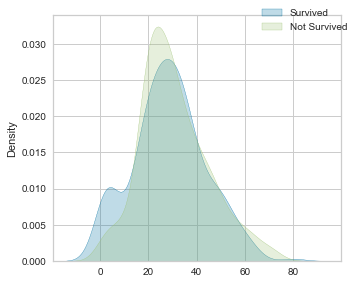

In [6]:
# If you want to compare distributions, but you are not sure if the data satisfy the parametric test conditions, 
# you can call the HTestAutoPilot Class.
# It will help you in this decision.
HTestAutoPilot.independent_difference(survived_age, not_survived_age, label1='Survived', label2='Not Survived')

In [7]:
# If you know which test to use, you can call it directly from the HypothesisTester Class
HypothesisTester.t_test(survived_age, not_survived_age, show_graph=False)

,T-test
T,-2.04603
dof,598.841215
alternative,two-sided
p-val,0.04119
CI95%,"[-4.47, -0.09]"
cohen-d,0.157486
BF10,0.657
power,0.541418
H0,difference in mean equal to zero
H1,difference in mean not equal to zero
